In [29]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

### Глубина решающего дерева

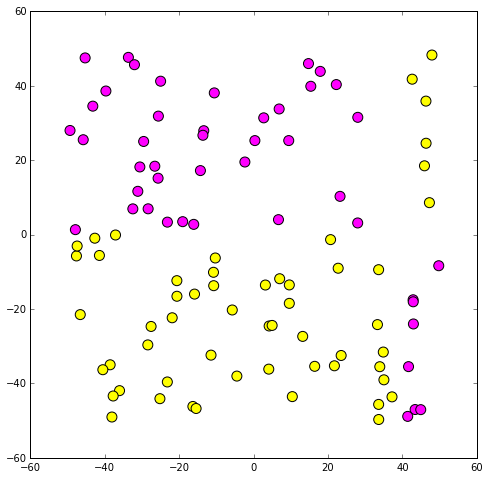

In [12]:
X = -50 + 100 * np.random.rand(100, 2)
Y = np.sign((X[:, 0] - 40) * X[:, 1])
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=Y, s=100, cmap='spring')

DT MSE (max_depth = 1) =  0.481599347205
DT MSE (max_depth = 2) =  0.0
DT MSE (max_depth = 3) =  0.0


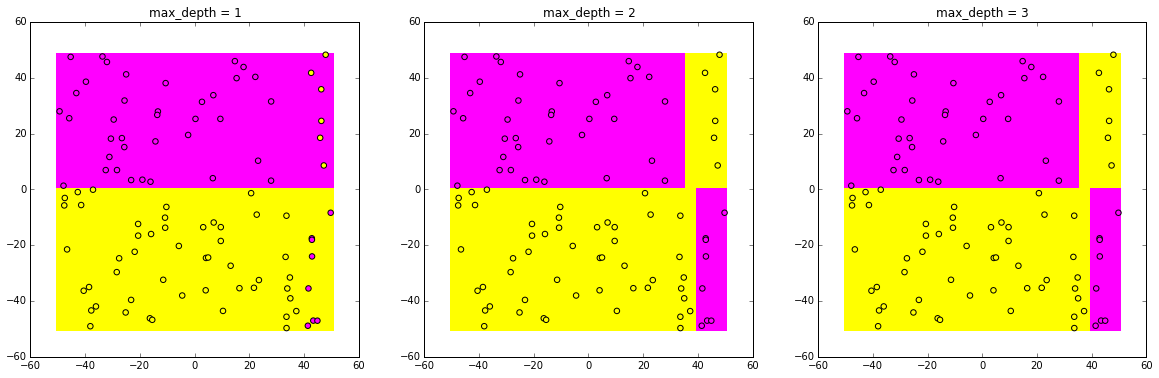

In [13]:
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.5),
                         np.arange(y_min, y_max, 0.5))
plt.figure(figsize=(20, 6))
for i in range(3):
    clf = DecisionTreeRegressor(random_state=42, max_depth = i + 1)

    clf.fit(X, Y)
    xx, yy = get_grid(X)
    predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.subplot2grid((1, 3), (0, i))
    plt.pcolormesh(xx, yy, predicted, cmap='spring')
    plt.scatter(X[:, 0], X[:, 1], c=Y, s=30, cmap='spring')
    plt.title('max_depth = ' + str(i + 1))
    print 'DT MSE (max_depth = ' + str(i+1) + ') = ', mean_squared_error(Y.reshape(-1, 1), clf.predict(X))

**Вывод**: если вам известно, что в задаче необходимо учитывать взаимодействие $N$ признаков, корректным решением будет ограничивать глубину деревьев в градиентном бустинге числом, большим $N$. 

### Число деревьев в композициях

Модельные данные:

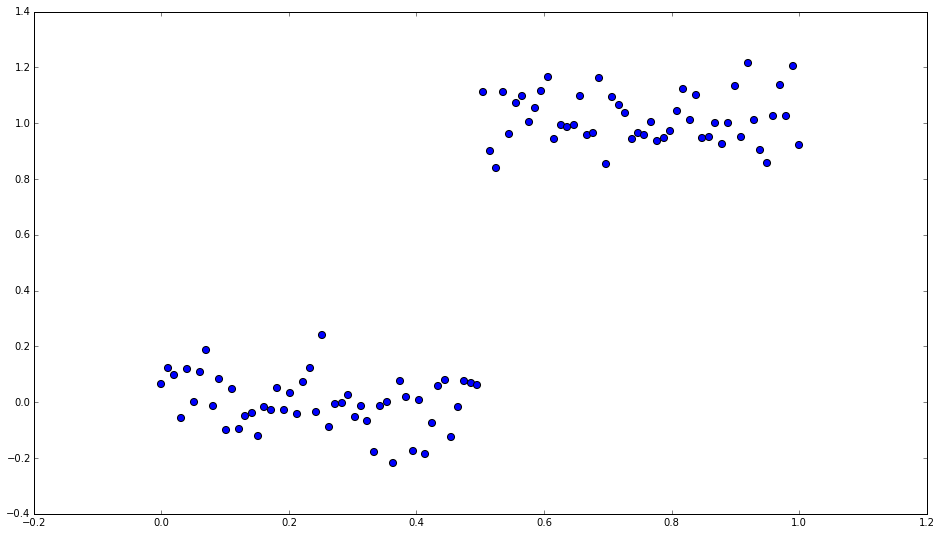

In [14]:
X_train = np.linspace(0, 1, 100)
X_test = np.linspace(0, 1, 1000)

@np.vectorize
def target(x):
    return x > 0.5

Y_train = target(X_train) + np.random.randn(*X_train.shape) * 0.1

plt.figure(figsize = (16, 9))
plt.scatter(X_train, Y_train, s=50)

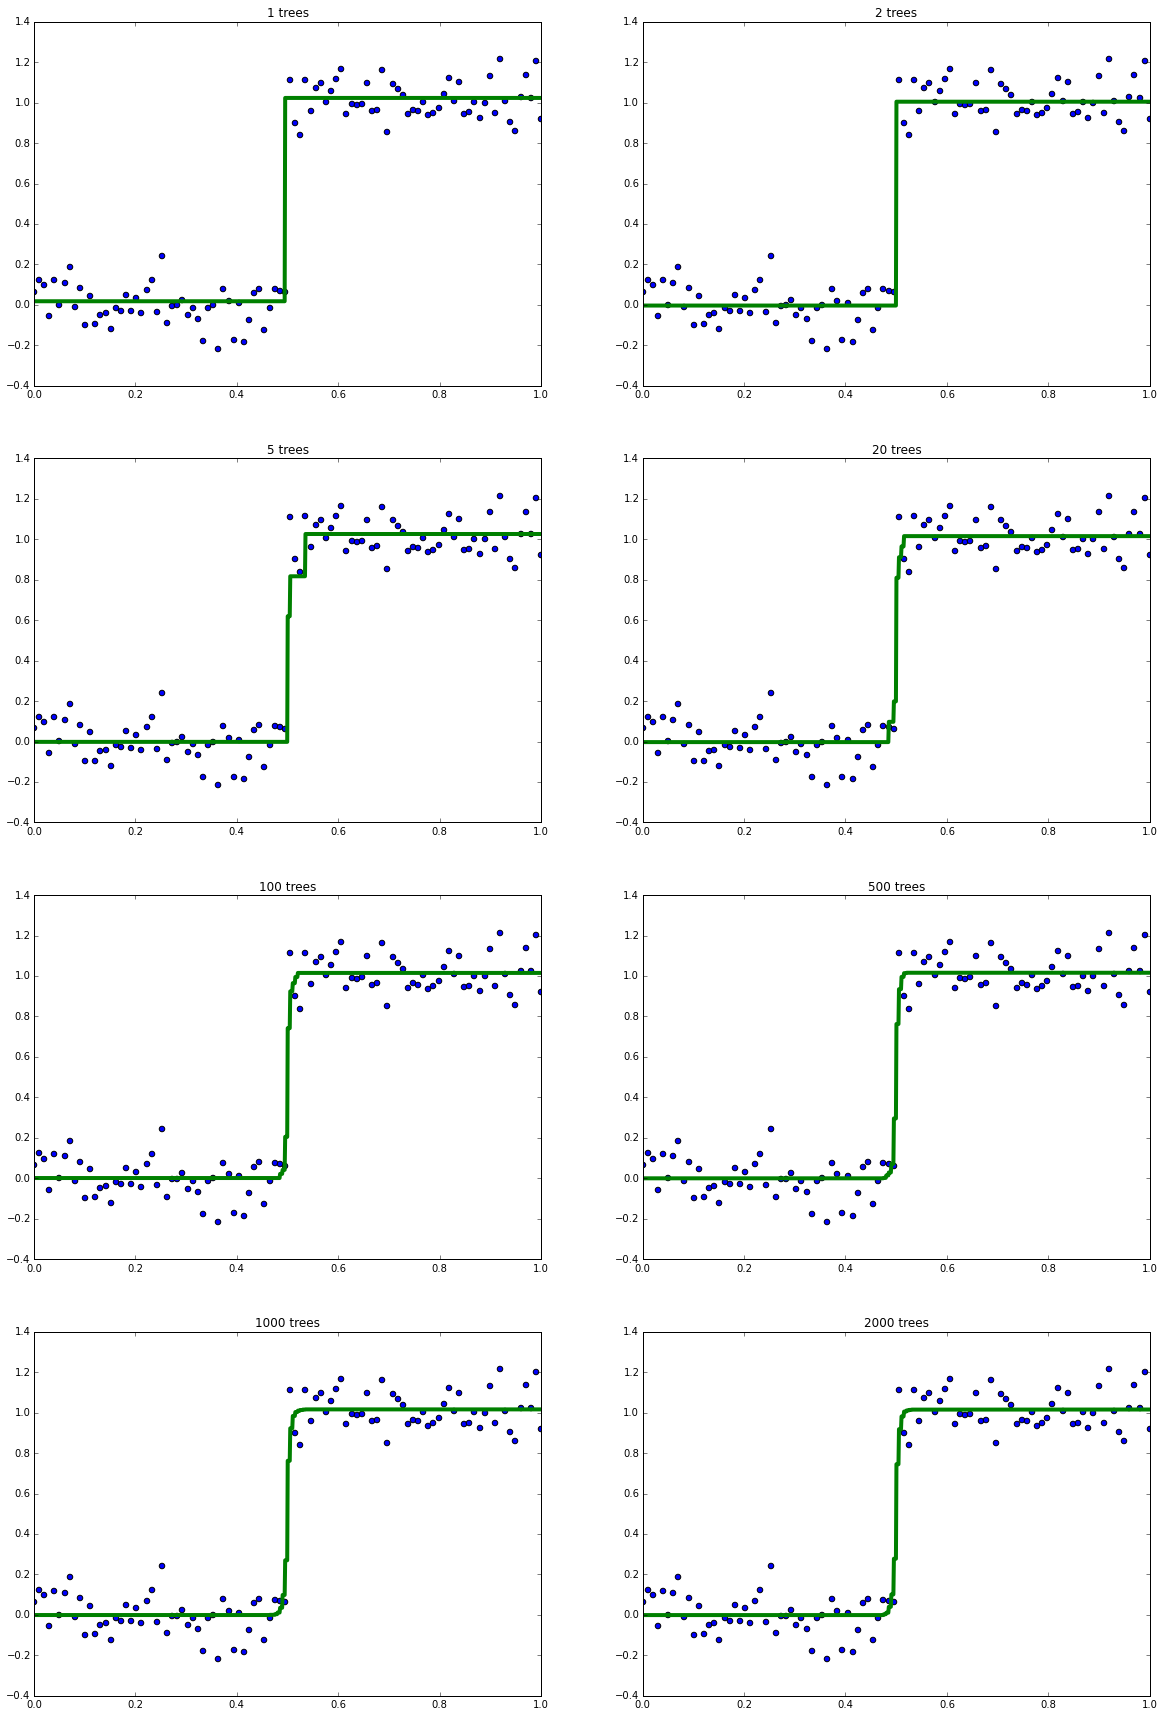

In [17]:
reg = BaggingRegressor(DecisionTreeRegressor(max_depth=1))
plt.figure(figsize=(20, 30))
sizes = [1, 2, 5, 20, 100, 500, 1000, 2000]
for i, s in enumerate(sizes):
    reg.n_estimators = s
    reg.fit(X_train.reshape(-1, 1), Y_train)
    plt.subplot(4, 2, i+1)
    plt.xlim([0, 1])
    plt.scatter(X_train, Y_train, s=30)
    plt.plot(X_test, reg.predict(X_test.reshape(-1, 1)), c='green', linewidth=4)
    plt.title('{} trees'.format(s))

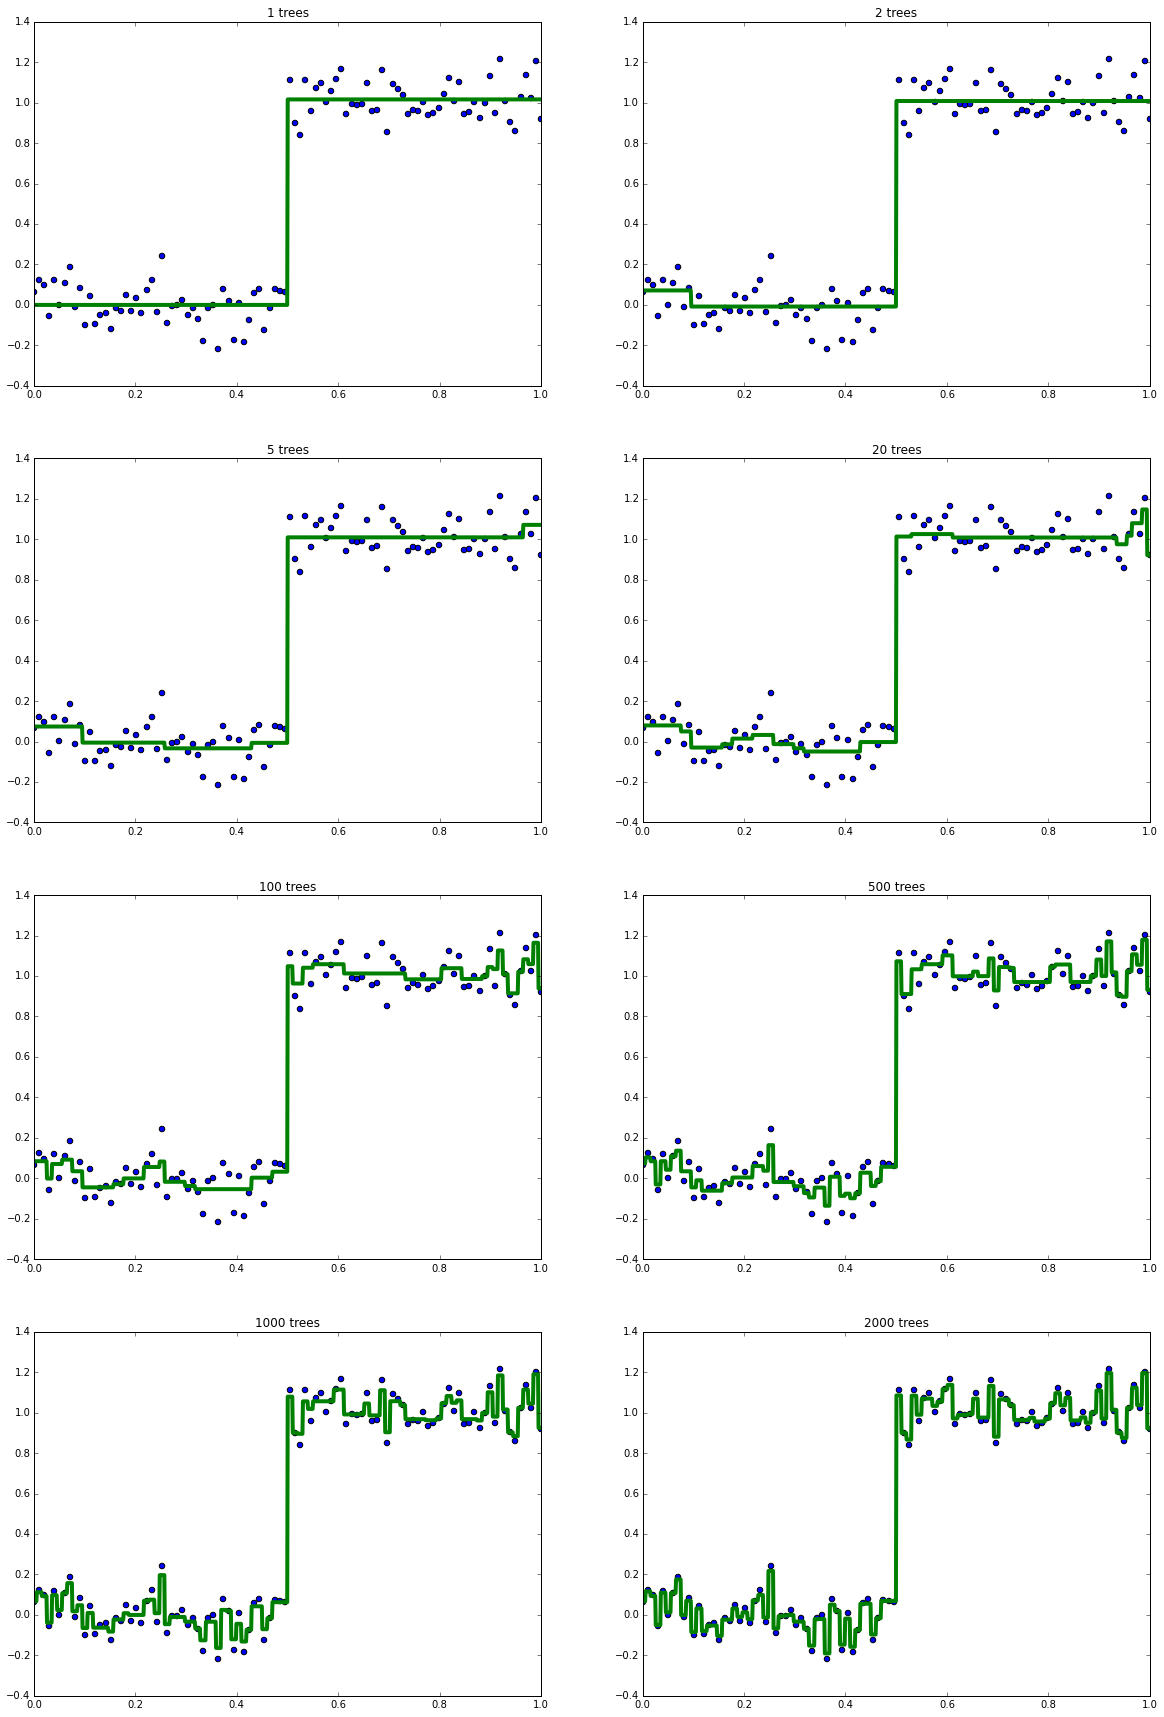

In [18]:
reg = GradientBoostingRegressor(max_depth=1, learning_rate=1, warm_start=True)
plt.figure(figsize=(20, 30))
sizes = [1, 2, 5, 20, 100, 500, 1000, 2000]
for i, s in enumerate(sizes):
    reg.n_estimators = s
    reg.fit(X_train.reshape(-1, 1), Y_train)
    plt.subplot(4, 2, i+1)
    plt.xlim([0, 1])
    plt.scatter(X_train, Y_train, s=30)
    plt.plot(X_test, reg.predict(X_test.reshape(-1, 1)), c='green', linewidth=4)
    plt.title('{} trees'.format(s))

RF молодец, а GB переобучился

Уменьшаем темп обучения:

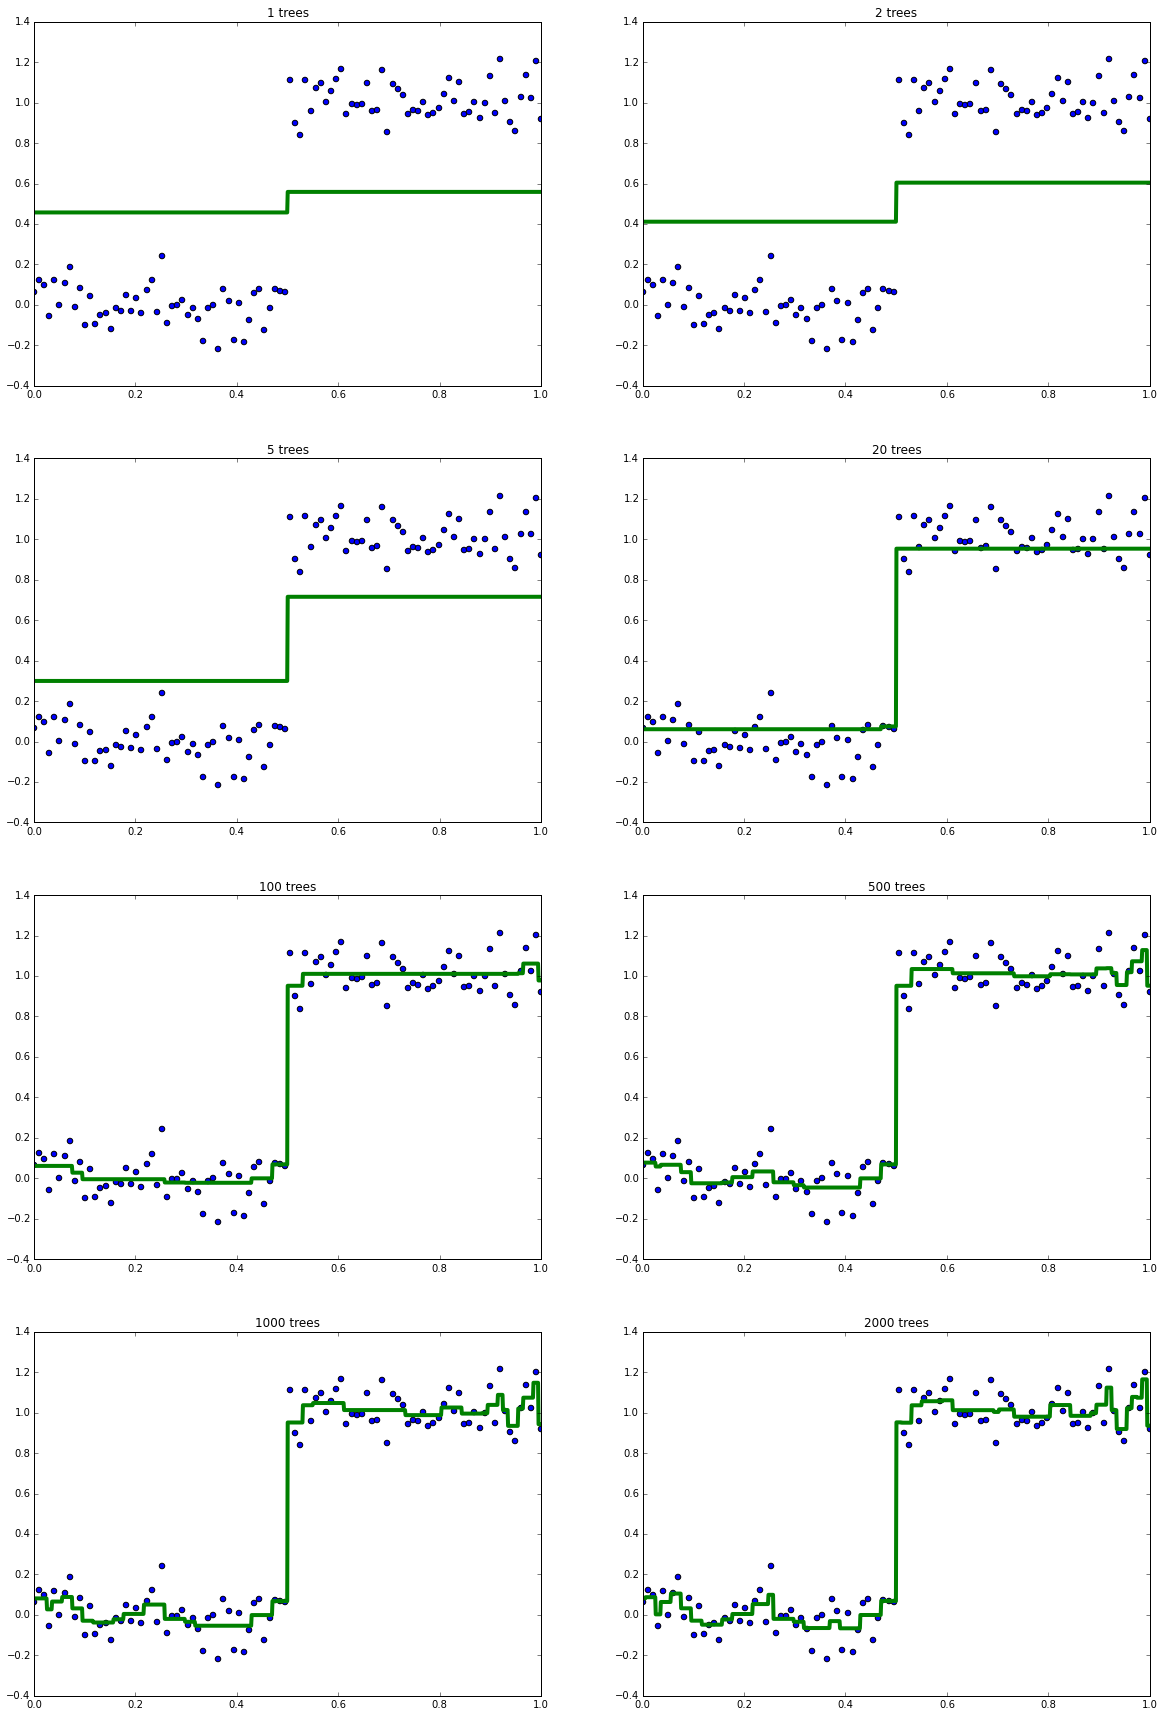

In [19]:
reg = GradientBoostingRegressor(max_depth=1, learning_rate=0.1, warm_start=True)
plt.figure(figsize=(20, 30))
sizes = [1, 2, 5, 20, 100, 500, 1000, 2000]
for i, s in enumerate(sizes):
    reg.n_estimators = s
    reg.fit(X_train.reshape(-1, 1), Y_train)
    plt.subplot(4, 2, i+1)
    plt.xlim([0, 1])
    plt.scatter(X_train, Y_train, s=30)
    plt.plot(X_test, reg.predict(X_test.reshape(-1, 1)), c='green', linewidth=4)
    plt.title('{} trees'.format(s))

На реальных данных:

In [21]:
from sklearn import datasets
from sklearn.cross_validation import train_test_split

ds = datasets.load_diabetes()
X = ds.data
Y = ds.target
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.5)

MAX_ESTIMATORS = 250

gbclf = GradientBoostingRegressor(warm_start=True)
err_train_gb = []
err_test_gb = []
for i in range(1, MAX_ESTIMATORS+1):
    gbclf.n_estimators = i
    gbclf.fit(X_train, Y_train)
    err_train_gb.append(1 - gbclf.score(X_train, Y_train))
    err_test_gb.append(1 - gbclf.score(X_test, Y_test))

gbclf = BaggingRegressor()
err_train_bag = []
err_test_bag = []
for i in range(1, MAX_ESTIMATORS+1):
    gbclf.n_estimators = i
    gbclf.fit(X_train, Y_train)
    err_train_bag.append(1 - gbclf.score(X_train, Y_train))
    err_test_bag.append(1 - gbclf.score(X_test, Y_test))

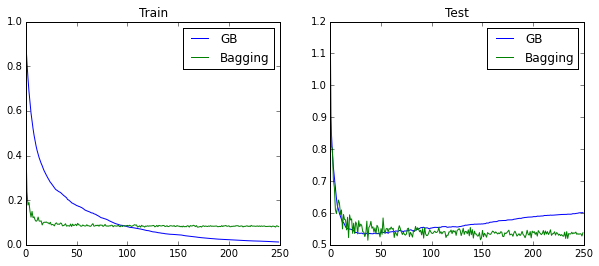

In [22]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(err_train_gb, label='GB')
plt.plot(err_train_bag, label='Bagging')
plt.legend()
plt.title('Train')
plt.subplot(1, 2, 2)
plt.plot(err_test_gb, label='GB')
plt.plot(err_test_bag, label='Bagging')
plt.legend()
plt.title('Test')

Снова GB переобучился, а Bagging молодец.

На других реальных данных ([Kaggle: Predicting a Biological Response](https://www.kaggle.com/c/bioresponse)) GB с разным темпом обучения:

In [23]:
import pandas as pd
from sklearn.cross_validation import KFold, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


data = pd.read_csv('train.csv')
X = data.ix[:, 1:].values
y = data.ix[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=241)

In [24]:
%%time
gbm = GradientBoostingClassifier(n_estimators=250, learning_rate=0.2, verbose=True).fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           1.2613           33.86s
         2           1.1713           27.90s
         3           1.1007           25.77s
         4           1.0524           24.72s
         5           1.0125           24.55s
         6           0.9736           24.40s
         7           0.9441           24.20s
         8           0.9194           24.41s
         9           0.8950           24.53s
        10           0.8786           24.60s
        20           0.7166           20.91s
        30           0.5979           19.02s
        40           0.5150           19.62s
        50           0.4578           17.45s
        60           0.3984           16.06s
        70           0.3420           15.47s
        80           0.3078           14.11s
        90           0.2588           13.05s
       100           0.2241           11.96s
       200           0.0767            3.73s
Wall time: 18.4 s


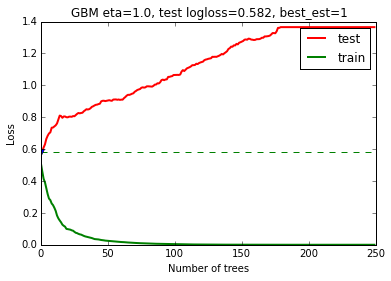

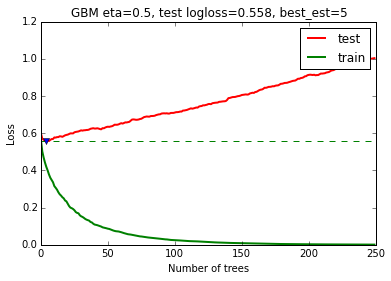

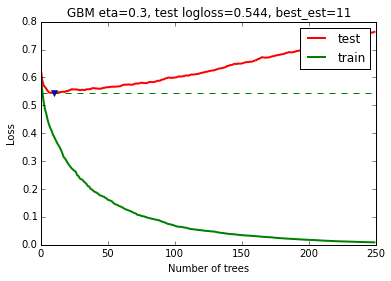

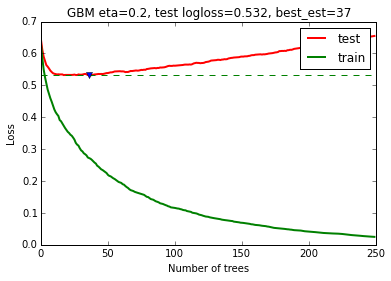

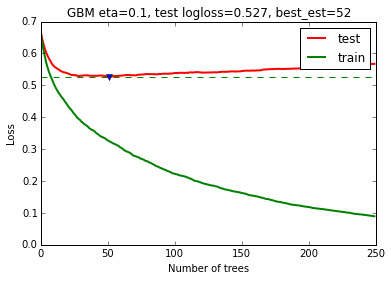

In [25]:
import numpy as np
from sklearn.metrics import log_loss

for learning_rate in [1, 0.5, 0.3, 0.2, 0.1]:

    gbm = GradientBoostingClassifier(n_estimators=250, learning_rate=learning_rate, random_state=241).fit(X_train, y_train)
    
    l = log_loss

    test_deviance = np.zeros((gbm.n_estimators,), dtype=np.float64)
    for i, y_pred in enumerate(gbm.staged_decision_function(X_test)):
        y_pred = 1.0 / (1.0 + np.exp(-y_pred))
        test_deviance[i] = l(y_test, y_pred)

    train_deviance = np.zeros((gbm.n_estimators,), dtype=np.float64)
    for i, y_pred in enumerate(gbm.staged_decision_function(X_train)):
        y_pred = 1.0 / (1.0 + np.exp(-y_pred))
        train_deviance[i] = l(y_train, y_pred)

    plt.figure()
    plt.plot(test_deviance, 'r', linewidth=2)
    plt.plot(train_deviance, 'g', linewidth=2)
    plt.legend(['test', 'train'])
    plt.plot([0, train_deviance.shape[0]], [test_deviance.min(), test_deviance.min()], 'g--')
    plt.plot([test_deviance.argmin()], [test_deviance.min()], 'v')
    plt.title('GBM eta=%.1f, test logloss=%.3f, best_est=%d' % (learning_rate, test_deviance.min(), test_deviance.argmin()+1))
    plt.xlabel('Number of trees')
    plt.ylabel('Loss')

Случайный лес с таким же количеством базовых алгоритмов уступает градиентному бустингу:

In [26]:
rf = RandomForestClassifier(n_estimators=52, random_state=241).fit(X_train, y_train)
print 'Train RF log-loss =', log_loss(y_train, rf.predict_proba(X_train))
print 'Test RF log-loss = ', log_loss(y_test, rf.predict_proba(X_test))

Train RF log-loss = 0.156663363324
Test RF log-loss =  0.537760794387


Для достижения такого же качества случайному лесу требуется гораздо большее число базовых алгоритмов:

In [27]:
for n_estimators in xrange(10, 101, 10):
    rf = RandomForestClassifier(n_estimators=n_estimators, n_jobs=4).fit(X_train, y_train)
    print n_estimators, 'trees: train log-loss =', log_loss(y_train, rf.predict_proba(X_train)), 'test log-loss =', log_loss(y_test, rf.predict_proba(X_test))

10 trees: train log-loss = 0.164120207125 test log-loss = 0.779411540364
20 trees: train log-loss = 0.155257881364 test log-loss = 0.587635638099
30 trees: train log-loss = 0.159999089273 test log-loss = 0.536579572125
40 trees: train log-loss = 0.159763645297 test log-loss = 0.524674595786
50 trees: train log-loss = 0.15599545857 test log-loss = 0.528954509698
60 trees: train log-loss = 0.155692810944 test log-loss = 0.524035092992
70 trees: train log-loss = 0.158324336358 test log-loss = 0.52303739651
80 trees: train log-loss = 0.154723197757 test log-loss = 0.527422113567
90 trees: train log-loss = 0.155750779925 test log-loss = 0.526007424256
100 trees: train log-loss = 0.152082676876 test log-loss = 0.525289612903


Итак:
* GB переобучается прии большом числе деревьев, RF нет
* При фиксированном не очень большом числе деревьев качество GB лучше, чем у RF.
* У GB число деревьев (n_estimators) и темп обучения (learning_rate) связаны: чем меньше последний, тем лучше, но дольше.

Пояснение последнего вывода на градиентном спуске: будем делать градиентный спуск с зашумленным вектором градиента (примерно то, что делает градиентный бстинг).

In [33]:
def fun(x, y):
    return x**2 + 2 * y ** 2
   
def grad(x, y):
    return np.array([2 * x, 4 * y])

def make_data():
    x = np.arange (-100, 100, 0.1)
    y = np.arange (-100, 100, 0.1)
    xgrid, ygrid = np.meshgrid(x, y)
    zgrid = fun(xgrid, ygrid)
#    zgrid = np.sin (xgrid) * np.sin (ygrid) / (xgrid * ygrid)
    return xgrid, ygrid, zgrid


def gradient_descent(numIterations, eta, noise):
    ans = np.array([-70, 80])
    x_points = [ans[0]]
    y_points = [ans[1]]
    for iter in range(0, numIterations):
        ans = ans - eta * (grad(ans[0], ans[1]) + noise * np.random.randn(2))
        x_points.append(ans[0])
        y_points.append(ans[1])
    return (x_points, y_points)

C:\Anaconda2\lib\site-packages\matplotlib\collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
C:\Anaconda2\lib\site-packages\matplotlib\text.py:52: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if rotation in ('horizontal', None):
C:\Anaconda2\lib\site-packages\matplotlib\text.py:54: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif rotation == 'vertical':


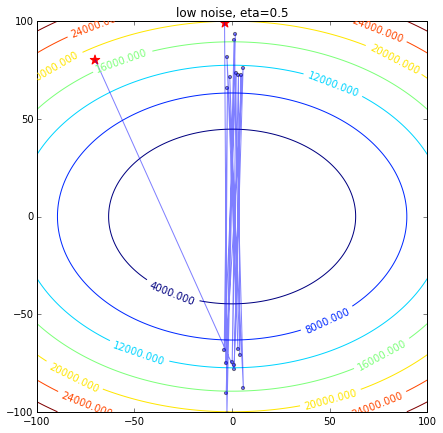

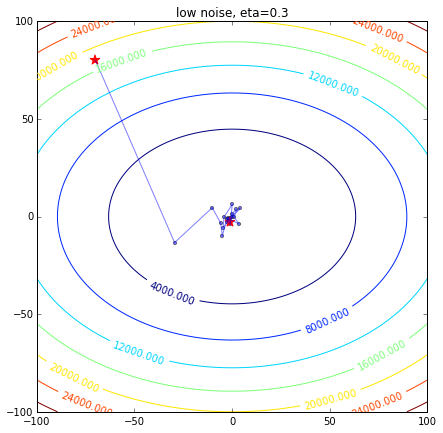

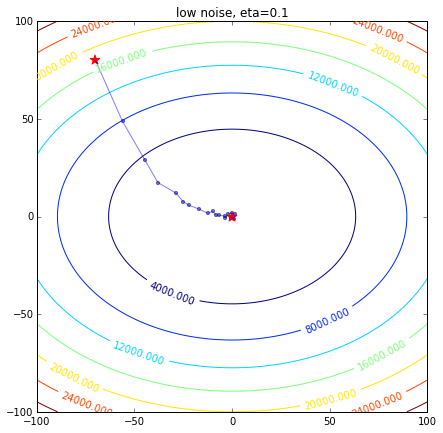

In [34]:
import numpy as np
from sklearn.metrics import log_loss
X, Y, Z = make_data()

for learning_rate in [0.5, 0.3, 0.1]:
    x_points, y_points = gradient_descent(20, learning_rate, 10)
    plt.figure(figsize = (7, 7))
    CS = plt.contour(X, Y, Z)
    plt.clabel(CS, inline=1, fontsize=10)
    plt.plot(x_points, y_points, linestyle = '-', color = 'blue', alpha = 0.5)
    plt.scatter(x_points[1:-1], y_points[1:-1], marker = '.', s=40, alpha = 0.5)
    plt.scatter([x_points[0], x_points[-1]], [y_points[0], y_points[-1]], 
                marker = '*', s=100, color = 'red')
    
    plt.xlim([-100, 100])
    plt.ylim([-100, 100])
    plt.title('low noise, eta=%.1f' % learning_rate)

Больше шум (соответствует более бедному семейству алгоритмов):

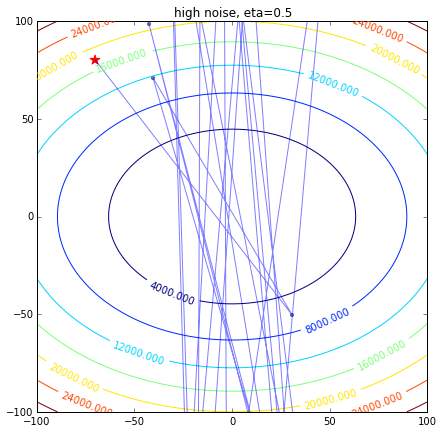

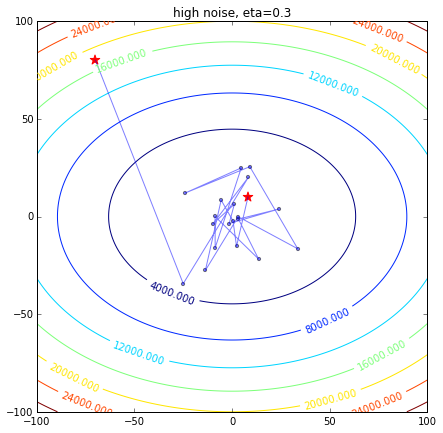

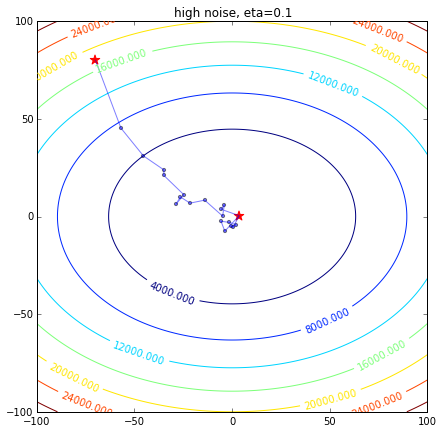

In [35]:
import numpy as np
from sklearn.metrics import log_loss
X, Y, Z = make_data()

for learning_rate in [0.5, 0.3, 0.1]:
    x_points, y_points = gradient_descent(20, learning_rate, 50)
    plt.figure(figsize = (7, 7))
    CS = plt.contour(X, Y, Z)
    plt.clabel(CS, inline=1, fontsize=10)
    plt.plot(x_points, y_points, linestyle = '-', color = 'blue', alpha = 0.5)
    plt.scatter(x_points[1:-1], y_points[1:-1], marker = '.', s=40, alpha = 0.5)
    plt.scatter([x_points[0], x_points[-1]], [y_points[0], y_points[-1]], 
                marker = '*', s=100, color = 'red')
    
    plt.xlim([-100, 100])
    plt.ylim([-100, 100])
    plt.title('high noise, eta=%.1f' % learning_rate)

С уменьшением размера шага градиентному бустингу требуется больше базовых алгоритмов для достижения приемлемого качества композиции, однако при этом сходимость такого процесса надежнее.

### Настройка RF и GB

RF:
* Сначала: фиксируем не очень большое число деревьев, настраиваем max_features.
* Затем: параметры сложности дерева (max_depth, min_samples_Split, min_samples_leaf).

GB:
* Сначала настраиваем max_depth, затем все остальное.
* На этапе настройки берем побольше learning_rate и меньше деревьев, когда параметры настроены, берем маленький learning_rate и тогда эффекта переобучения при росте n_estimators практически не будет.

### Качество аппроксимации зависимостей деервьями

Модельные данные:

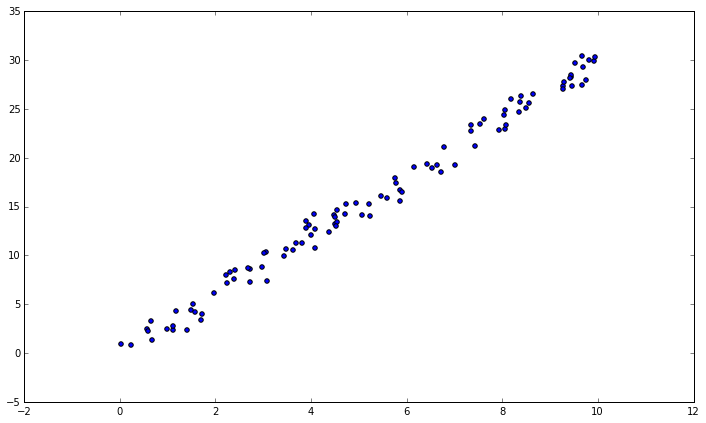

In [28]:
from numpy.random import rand, randn

set_size = 100
lin_coef = 3
sigma = 1

X_train = (rand(set_size) * 10).reshape(-1, 1)
Y_train = X_train * 3 + sigma * randn(set_size).reshape(-1, 1)
plt.figure(figsize=(12, 7))
plt.scatter(X_train, Y_train)

In [30]:
lr = LinearRegression()
lr.fit(X_train, Y_train)
tree = DecisionTreeRegressor()
tree.fit(X_train, Y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, random_state=None,
           splitter='best')

LR train MSE =  0.879095149717
DT train MSE =  0.0


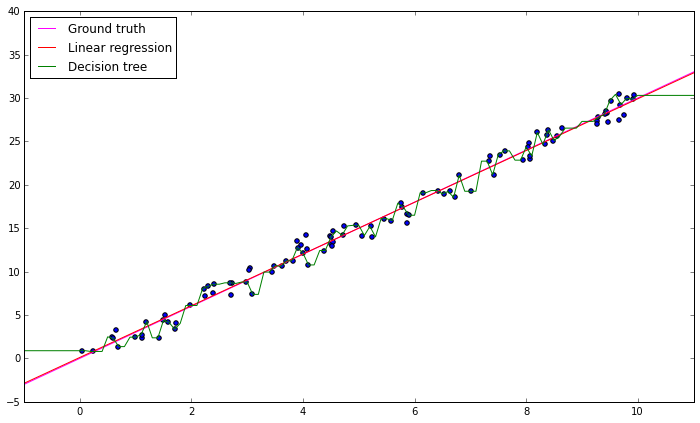

In [31]:
from numpy.random import rand, randn

grid = np.arange(-1, 12, 0.1).reshape(-1, 1)

plt.figure(figsize=(12, 7))
plt.scatter(X_train, Y_train)
plt.plot(grid, lin_coef * grid, 'magenta')
plt.plot(grid, lr.predict(grid), 'red',)
plt.plot(grid, tree.predict(grid), 'green')
plt.xlim([-1, 11])
plt.legend(['Ground truth', 'Linear regression', 'Decision tree'], loc=0)
print 'LR train MSE = ', mean_squared_error(Y_train, lr.predict(X_train))
print 'DT train MSE = ', mean_squared_error(Y_train, tree.predict(X_train))

Если новые данные были получены из другой области пространства ответов, например, из отрезка $[20; 30].$:

LR test MSE =  1.02968663845
DT test MSE =  2013.39215125


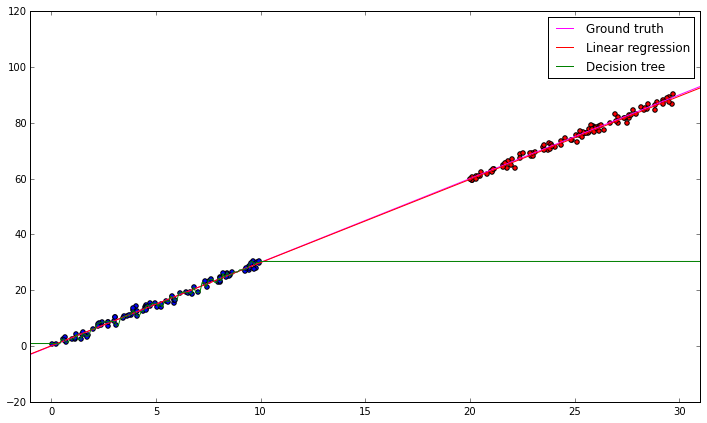

In [32]:
from numpy.random import rand, randn

grid = np.arange(-1, 32, 0.1).reshape(-1, 1)

X_test = (20 + rand(set_size) * 10).reshape(-1, 1)
Y_test = X_test * 3 + sigma * randn(set_size).reshape(-1, 1)
plt.figure(figsize=(12, 7))
plt.scatter(X_train, Y_train, c='blue')
plt.scatter(X_test, Y_test, c='red')

plt.plot(grid, lin_coef * grid, 'magenta')
plt.plot(grid, lr.predict(grid), 'red',)
plt.plot(grid, tree.predict(grid), 'green')
plt.xlim([-1, 31])
plt.legend(['Ground truth', 'Linear regression', 'Decision tree'], loc=0)
print 'LR test MSE = ', mean_squared_error(Y_test, lr.predict(X_test))
print 'DT test MSE = ', mean_squared_error(Y_test, tree.predict(X_test))

**Вывод**: решающие деревья (а потому и композиции над ними, в т.ч. градиентный бустинг) непригодны для экстраполяции функций.